In [1]:
%matplotlib inline
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from plots import *
from torch.distributions.normal import Normal
from torch.distributions.multivariate_normal import MultivariateNormal as mvn
from torch.distributions.one_hot_categorical import OneHotCategorical as cat
from torch.distributions.gamma import Gamma
from torch import logsumexp
import sys
import time
import datetime
sys.path.append('/home/hao/Research/probtorch/')
import probtorch
print('probtorch:', probtorch.__version__, 
      'torch:', torch.__version__, 
      'cuda:', torch.cuda.is_available())

probtorch: 0.0+5a2c637 torch: 1.0.0 cuda: True


In [2]:
N = 30
K = 3
D = 2

## Model Parameters
NUM_SAMPLES = 100
NUM_HIDDEN = 64
NUM_STATS = K+D*K+D*K
NUM_LATENTS = D * K
NUM_OBS = D
BATCH_SIZE = 10
NUM_EPOCHS = 4000
LEARNING_RATE = 1e-4
CUDA = False

In [3]:
Xs = torch.from_numpy(np.load('gmm_dataset/sequences.npy')).float()
Zs = torch.from_numpy(np.load('gmm_dataset/states.npy')).float()
# mus_true = torch.from_numpy(np.load('gmm_dataset/means.npy')).float()
# covs = torch.from_numpy(np.load('gmm_dataset2/covariances.npy')).float()
Pi = torch.from_numpy(np.load('gmm_dataset/init.npy')).float()
num_seqs = Zs.shape[0]

In [4]:
def StatsGMM(Xs, Zs, K, D):
    """
    Xs is B * N * D
    Zs is B * N * K
    stat1 corresponds I[z_n=1], ..., I[z_n=K]
    stat2 corresponds I[z_n=1]x_n, ..., I[z_n=K]x_n
    stat3 corresponds I[z_n=1]x_n**2, ..., I[z_n=K]x_n**2
    return B * (K+D*K+D*K)
    """
    stat1 = Zs.sum(1)
    stat2 = torch.mul(Zs.unsqueeze(-1).repeat(1, 1, 1, D), Xs.unsqueeze(-1).repeat(1, 1, 1, K).transpose(-1, -2)).sum(1) 
    stat3 = torch.mul(Zs.unsqueeze(-1).repeat(1, 1, 1, D), torch.mul(Xs, Xs).unsqueeze(-1).repeat(1, 1, 1, K).transpose(-1, -2)).sum(1) 
    return stat1, stat2, stat3, torch.cat((stat1, stat2.view(-1, D*K), stat3.view(-1, D*K)), dim=-1)

In [5]:
class Encoder(nn.Module):
    def __init__(self, num_obs=NUM_OBS,
                       num_stats=NUM_STATS,
                       num_hidden=NUM_HIDDEN,
                       num_latents=NUM_LATENTS):
        super(self.__class__, self).__init__()
        self.enc_stats = nn.Sequential(
            nn.Linear(num_obs, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, num_stats))
        self.enc_hidden = nn.Sequential(
            nn.Linear(num_stats, num_hidden),
            nn.ReLU())
        self.sigmas_log_alpha = nn.Sequential(
            nn.Linear(num_hidden, num_latents))
        self.sigmas_log_beta = nn.Sequential(
            nn.Linear(num_hidden, num_latents))
        
        self.enc_hidden2 = nn.Sequential(
            nn.Linear(num_stats, num_hidden),
            nn.ReLU())
        self.mus_mean = nn.Sequential(
            nn.Linear(num_hidden, num_latents))
        self.mus_log_std = nn.Sequential(
            nn.Linear(num_hidden, num_latents))
        
    def forward(self, obs, K, D, num_samples, batch_size):
        stats = self.enc_stats(obs).view(batch_size, N, -1).sum(1)
        hidden = self.enc_hidden(stats)
        alpha = torch.exp(self.sigmas_log_alpha(hidden)).view(-1, K, D) ## B * K * D
        beta = torch.exp(self.sigmas_log_beta(hidden)).view(-1, K, D) ## B * K * D
        precisions = Gamma(alpha, beta).sample((num_samples,)) ## S * B * K * D
        
        hidden2 = self.enc_hidden2(stats)                 
        mus_mean = self.mus_mean(hidden2).view(-1, K, D)
        mus_sigma = torch.exp(self.mus_log_std(hidden2).view(-1, K, D))
        mus = Normal(mus_mean, mus_sigma).sample((num_samples,))  
        return alpha, beta, precisions, mus_mean, mus_sigma, mus

In [6]:
def initialize():
    enc = Encoder()
    if CUDA:
        enc.cuda()
    optimizer =  torch.optim.Adam(list(enc.parameters()),lr=LEARNING_RATE, betas=(0.9, 0.99))    
    return enc, optimizer
enc, optimizer = initialize()

In [7]:
def log_joints_gmm(Z, Pi, mus, precisions, Xs, N, D, K, num_samples, batch_size):
    log_probs = torch.zeros((num_samples, batch_size)).float()
    ## priors on mus and sigmas, S * B
    log_probs = log_probs + Normal(torch.zeros((batch_size, K, D)), torch.ones((batch_size, K, D))).log_prob(mus).sum(-1).sum(-1)
    log_probs = log_probs + Gamma(torch.ones((batch_size, K, D)) * 2.0, torch.ones((batch_size, K, D)) * 2.0).log_prob(precisions).sum(-1).sum(-1)
    ## Z B-by-T-by-K
    log_probs = log_probs + cat(Pi).log_prob(Z).sum(-1)
    labels = Z.nonzero()
    sigmas = 1. / torch.sqrt(precisions)
    log_probs = log_probs + Normal(mus[:, labels[:, 0], labels[:, -1], :].view(-1, batch_size, N, D), sigmas[:, labels[:, 0], labels[:, -1], :].view(-1, batch_size, N, D)).log_prob(Xs).sum(-1).sum(-1)
    return log_probs

def rws(Xs, Zs, Pi, N, K, D, num_samples, batch_size):
    stat1, stat2, stat3, stats = StatsGMM(Xs, Zs, K, D)
    data = Xs.view(batch_size*N, -1)
    alpha, beta, precisions, mus_mean, mus_sigma, mus = enc(data, K, D, num_samples, batch_size)
    log_q =  Normal(mus_mean, mus_sigma).log_prob(mus).sum(-1).sum(-1) + Gamma(alpha, beta).log_prob(precisions).sum(-1).sum(-1)## S * B
    log_p = log_joints_gmm(Zs, Pi, mus, precisions, Xs, N, D, K, num_samples, batch_size)
    log_weights = log_p - log_q
    weights = torch.exp(log_weights - logsumexp(log_weights, dim=0)).detach()
    eubo = torch.mul(weights, log_weights).sum(0).mean()
    elbo = log_weights.mean(0).mean()
    ess = (1. / (weights ** 2).sum(0)).mean()
#     posterior_mean, posterior_nu, posterior_alpha, posterior_beta = conjugate_posterior(stat1, stat2, stat3, K, D, batch_size)
#     MCKl_inclusive, TrueKl_inclusive, MCKl_exclusive, TrueKl_exclusive = kls_gammas(weights, precisions, sigmas_alpha, sigmas_beta, posterior_alpha, posterior_beta, K, D)
    return eubo, elbo, ess

def shuffler(batch_Xs, batch_Zs, N, K, D, batch_size):
    indices = torch.cat([torch.randperm(N).unsqueeze(0) for b in range(batch_size)])
    indices_Xs = indices.unsqueeze(-1).repeat(1, 1, D)
    indices_Zs = indices.unsqueeze(-1).repeat(1, 1, K)
    return torch.gather(batch_Xs, 1, indices_Xs), torch.gather(batch_Zs, 1, indices_Zs)

In [16]:
EUBOs = []
ELBOs = []
ESSs = []
MCKls_inclusive = []
TrueKls_inclusive = []
MCKls_exclusive = []
TrueKls_exclusive = []

num_batches = int((Xs.shape[0] / BATCH_SIZE))
time_start = time.time()
for epoch in range(NUM_EPOCHS):
    indices = torch.randperm(num_seqs)

    EUBO = 0.0
    ELBO = 0.0
    ESS = 0.0
    for step in range(num_batches):
        optimizer.zero_grad()
        batch_indices = indices[step*BATCH_SIZE : (step+1)*BATCH_SIZE]
        batch_Xs = Xs[batch_indices]
        batch_Zs = Zs[batch_indices]
        batch_Xs, batch_Zs = shuffler(batch_Xs, batch_Zs, N, K, D, BATCH_SIZE)
        eubo, elbo, ess = rws(batch_Xs, batch_Zs, Pi, N, K, D, NUM_SAMPLES, BATCH_SIZE)
        eubo.backward()
        optimizer.step()
        EUBO += eubo.item()
        ELBO += elbo.item()
        ESS += ess.item()

    EUBO /= num_batches
    ELBO /= num_batches
    ESS /= num_batches
    
    EUBOs.append(EUBO)
    ELBOs.append(ELBO)
    ESSs.append(ESS)
    
#     time_end = time.time()
    if epoch % 10 == 0:
        time_end = time.time()
        print('epoch=%d, EUBO=%f, ELBO=%f, ESS=%.3f (%ds)' % (epoch, EUBO, ELBO, ESS, time_end - time_start))
        time_start = time.time()

epoch=0, EUBO=-184.890820, ELBO=-256.941636, ESS=1.377 (0s)
epoch=10, EUBO=-184.418908, ELBO=-260.249084, ESS=1.344 (3s)
epoch=20, EUBO=-184.463822, ELBO=-262.063447, ESS=1.369 (3s)
epoch=30, EUBO=-184.855548, ELBO=-262.138421, ESS=1.383 (3s)
epoch=40, EUBO=-184.913366, ELBO=-259.825817, ESS=1.379 (3s)
epoch=50, EUBO=-184.639140, ELBO=-258.884219, ESS=1.339 (3s)
epoch=60, EUBO=-184.228261, ELBO=-261.455544, ESS=1.386 (3s)
epoch=70, EUBO=-184.851100, ELBO=-261.799348, ESS=1.361 (3s)
epoch=80, EUBO=-184.336852, ELBO=-259.456241, ESS=1.369 (3s)
epoch=90, EUBO=-184.545139, ELBO=-262.051431, ESS=1.367 (3s)
epoch=100, EUBO=-184.675277, ELBO=-260.845804, ESS=1.365 (3s)
epoch=110, EUBO=-184.884428, ELBO=-260.391388, ESS=1.399 (3s)
epoch=120, EUBO=-184.285545, ELBO=-267.445352, ESS=1.338 (3s)
epoch=130, EUBO=-184.484566, ELBO=-261.574653, ESS=1.385 (3s)
epoch=140, EUBO=-184.912664, ELBO=-260.678639, ESS=1.393 (3s)
epoch=150, EUBO=-184.316637, ELBO=-259.293322, ESS=1.360 (3s)
epoch=160, EUBO=-18

KeyboardInterrupt: 

In [10]:
def plot_results(EUBOs, ELBOs, ESSs, num_samples, num_epochs, lr):
    fig = plt.figure(figsize=(30, 30))
    fig.tight_layout()
    ax1 = fig.add_subplot(3, 1, 1)
    ax2 = fig.add_subplot(3, 1, 2)
    ax3 = fig.add_subplot(3, 1, 3)
    ax1.plot(EUBOs, 'r', label='EUBOs')
    ax1.plot(ELBOs, 'b', label='ELBOs')
    ax2.plot(TrueKls_exclusive, '#66b3ff', label='true exclusive KL')
    ax2.plot(MCKls_exclusive, '#ff9999', label='est exclusive KL')
    ax2.plot(TrueKls_inclusive, '#99ff99', label='true inclusive KL')
    ax2.plot(MCKls_inclusive, 'gold', label='est inclusive KL')
    
    ax1.tick_params(labelsize=18)
    ax3.plot(np.array(ESSs) / num_samples, 'm', label='ESS')
    ax1.set_title('epoch=%d, batch_size=%d, lr=%.1E, samples=%d' % (num_epochs, BATCH_SIZE, lr, num_samples), fontsize=18)
    ax1.set_ylim([-300, -150])
    ax1.legend()
    ax2.set_ylim([-50, 50])
    ax2.legend()
    ax3.legend()
    ax2.tick_params(labelsize=18)
    ax3.tick_params(labelsize=18)
    plt.savefig('oneshot_learn_both_lr=%.1E_samples=%d.svg' % (lr, num_samples))

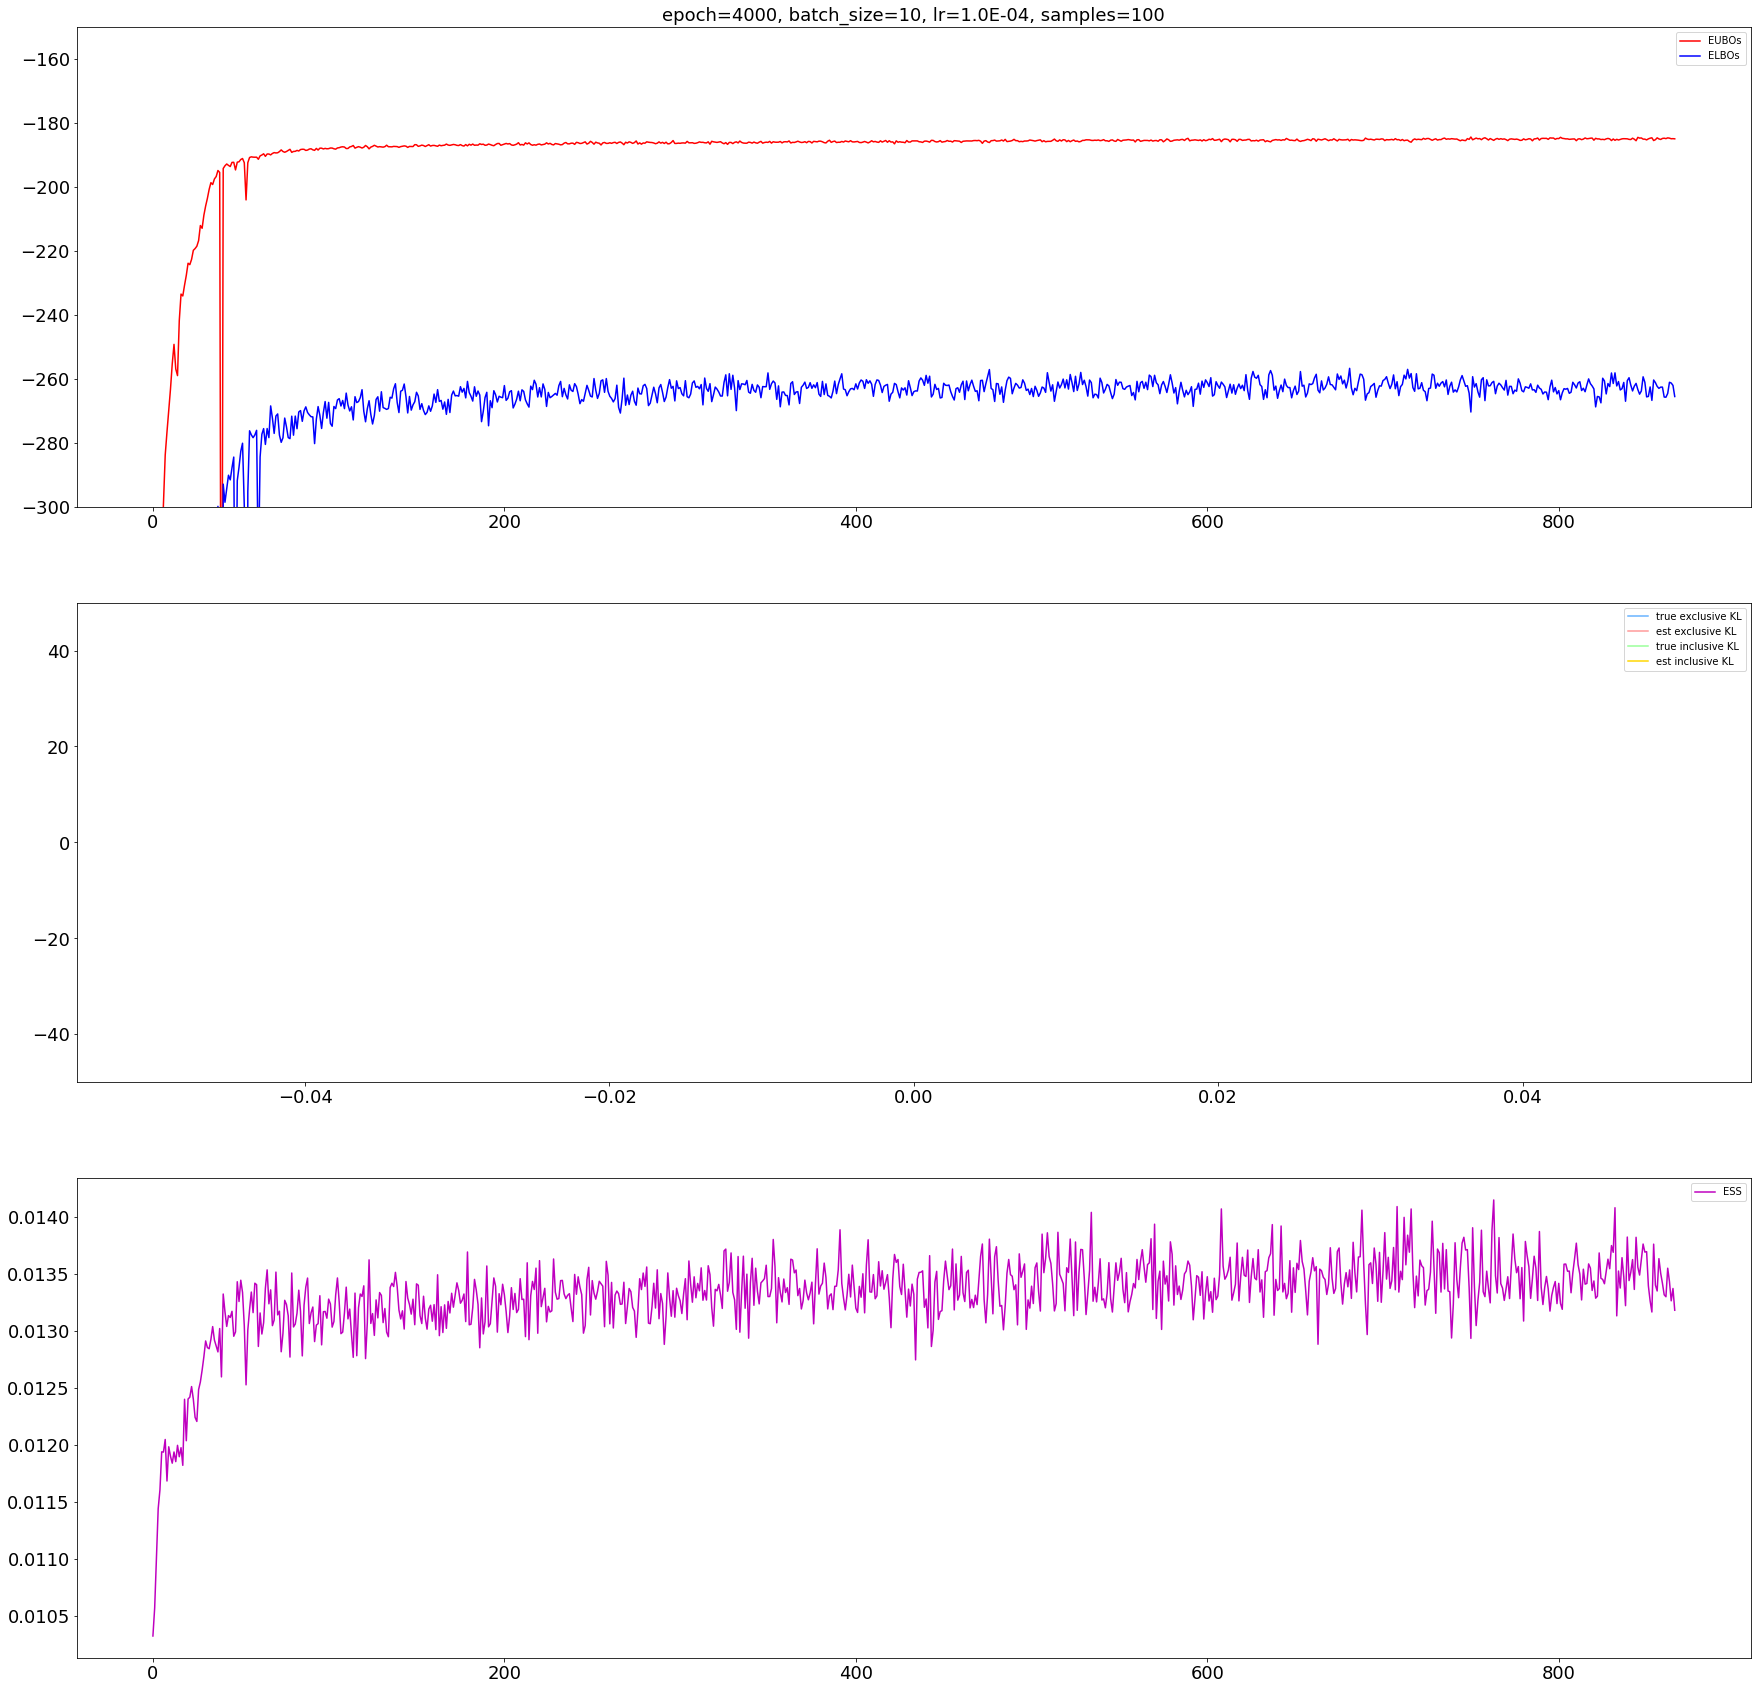

In [11]:
plot_results(EUBOs, ELBOs, ESSs, NUM_SAMPLES, NUM_EPOCHS, LEARNING_RATE)

In [17]:
BATCH_SIZE = 50

indices = torch.randperm(num_seqs)
batch_indices = indices[0*BATCH_SIZE : (0+1)*BATCH_SIZE]
batch_Xs = Xs[batch_indices]
batch_Zs = Zs[batch_indices]
# batch_Covs = covs[batch_indices]
# batch_Mus = mus_true[batch_indices]
batch_Xs, batch_Zs = shuffler(batch_Xs, batch_Zs, N, K, D, BATCH_SIZE)

data = batch_Xs.view(BATCH_SIZE*N, -1)
alpha, beta, precisions, mus_mean, mus_sigma, mus = enc(data, K, D, 1, BATCH_SIZE)

In [18]:
def plot_predictions(Xs, Zs, precisions_pred, mus_pred, batch_size):
    colors = ['r', 'b', 'gold']
    Xs = Xs.data.numpy()
    Zs = Zs.data.numpy()
    mus_pred = mus_pred.data.numpy()
    precisions_pred = precisions_pred.data.numpy()
    
    fig = plt.figure(figsize=(40, 80))
    for b in range(batch_size):
        z = Zs[b]
        x = Xs[b]
        mus = mus_pred[b]
        precision = precisions_pred[b]
 
        ax = fig.add_subplot(int(batch_size / 5), 5, b+1)
        assignments = np.nonzero(z)[1]
        for k in range(K):
            xk = x[np.where(assignments == k)]
            cov_single = np.diag(1. / precision[k])
            ax.scatter(xk[:,0], xk[:,1], c=colors[k])
            plot_cov_ellipse(cov=cov_single, pos=mus[k], nstd=2, ax=ax, alpha=0.2, color=colors[k])
            ax.set_ylim([-10, 10])
            ax.set_xlim([-10, 10])
    plt.tight_layout()
    plt.savefig('oneshot.svg')

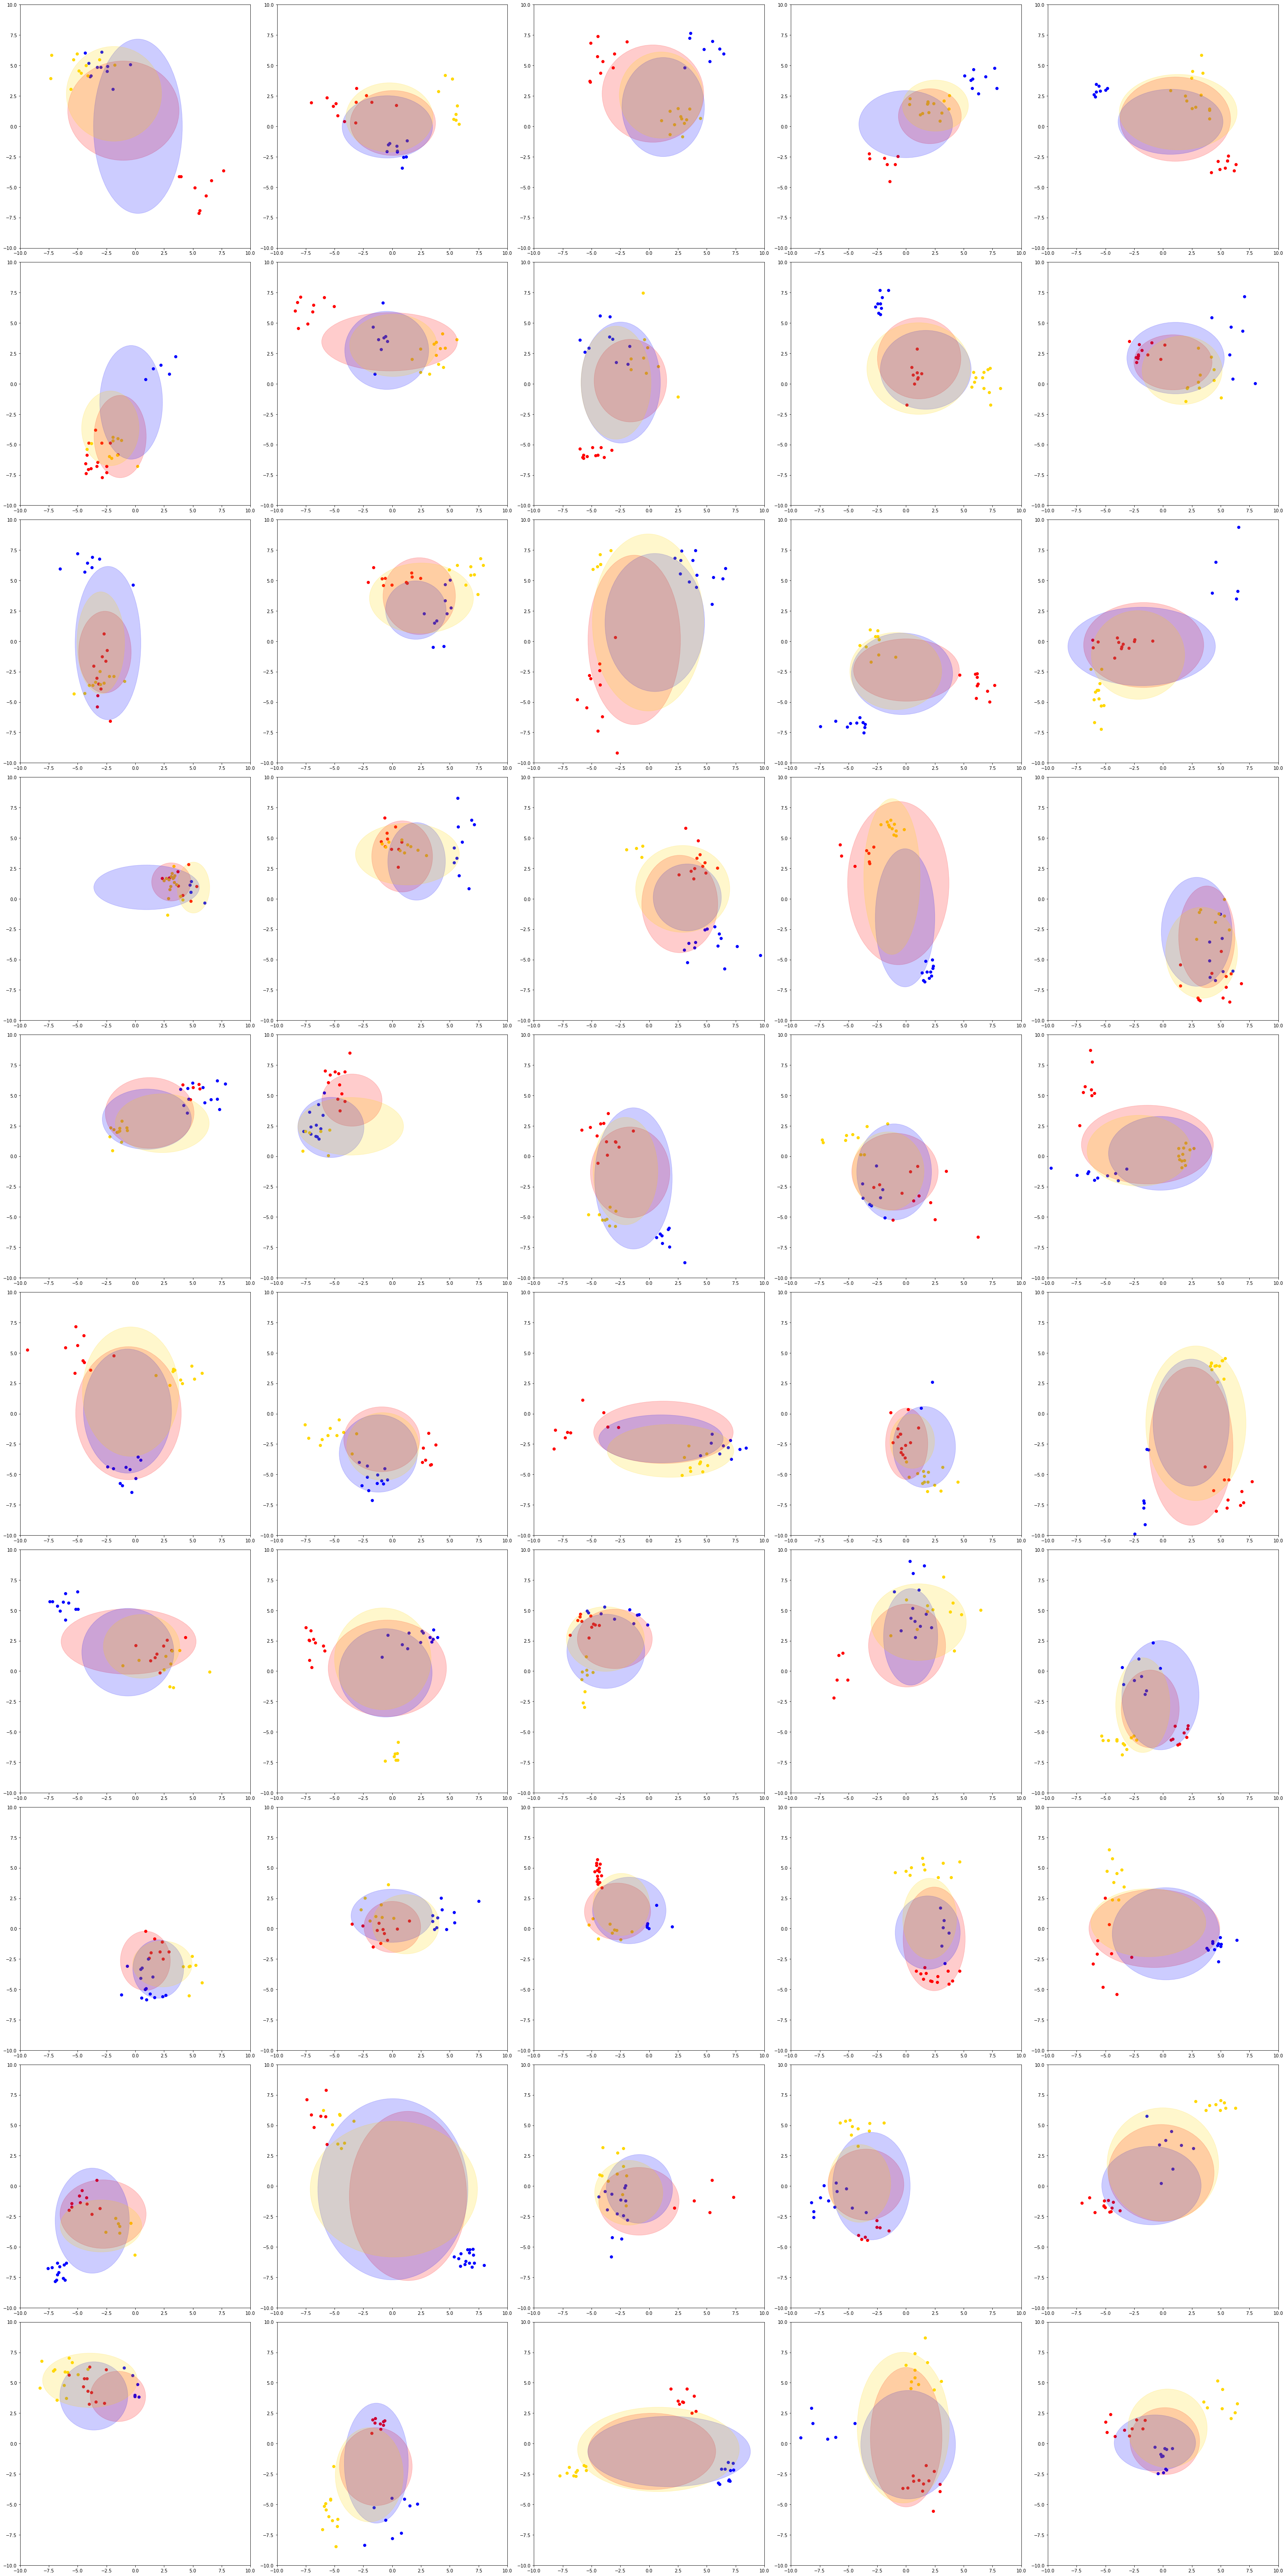

In [19]:
E_precisions = alpha / beta
E_mus = mus_mean
plot_predictions(batch_Xs, batch_Zs, E_precisions, E_mus, BATCH_SIZE)